**Load data and libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy
import sklearn
from datetime import datetime
import locale
import time
from random import randint
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

In [4]:
pd.set_option('display.min_rows', 30)

In [49]:
X_train = pd.read_csv("../Data for modelling/X_train_MP03.csv", header = 0, sep=',')
X_train.head()

,Hour,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,is_kul_holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED
0,19,False,False,False,False,False,False,True,0,False,22.338912,0.000000,0.000000,0.305309
1,14,False,False,False,True,False,False,False,0,False,19.039233,0.000003,0.000009,0.237562
2,8,False,False,True,False,False,False,False,0,False,13.543212,0.000250,0.000222,0.040694
3,9,False,False,False,False,False,True,False,0,False,2.187339,0.000000,0.000000,0.174643
4,16,False,False,False,False,True,False,False,0,False,19.543486,0.000000,0.001102,0.761034


In [50]:
y_train = pd.read_csv("../Data for modelling/y_train_MP03.csv", header = 0, sep=',')
y_train.head()

,laeq
0,54.157333
1,56.597389
2,55.840289
3,50.856083
4,55.680639


In [51]:
X_test = pd.read_csv("../Data for modelling/X_test_MP03.csv", header = 0, sep=',')
X_test.head()

,Hour,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,is_kul_holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED
0,23,False,False,False,True,False,False,False,0,False,10.390285,0.000000,0.000019,0.010015
1,15,False,True,False,False,False,False,False,1,False,18.693508,0.000000,0.000019,0.118935
2,16,False,False,True,False,False,False,False,0,False,12.659890,0.000008,0.002485,0.509660
3,15,False,False,False,False,False,False,True,0,False,25.085912,0.000000,0.000000,0.812948
4,23,False,False,False,False,False,True,False,0,False,7.584388,0.000000,0.000031,0.409575


In [52]:
y_test = pd.read_csv("../Data for modelling/y_test_MP03.csv", header = 0, sep=',')
y_test.head()

,laeq
0,51.781389
1,56.372861
2,55.976833
3,52.485639
4,52.144457


In [53]:
print(len(X_train), len(y_train), len(X_test), len(y_test))
#Adds up to 8760, imputation worked

7008 7008 1752 1752


**Preprocessing/feature engineering (almost all of this section was moved to preprocessing notebook)**

In [54]:
#Train hour trig encoding
X_train['hour_sin'] = X_train['Hour'].apply(lambda x: math.sin(2*math.pi * x / 24))
X_train['hour_cos'] = X_train['Hour'].apply(lambda x: math.cos(2*math.pi * x / 24))
X_train = X_train.drop('Hour', axis = 1)
display(X_train)

,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,is_kul_holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED,hour_sin,hour_cos
0,False,False,False,False,False,False,True,0,False,22.338912,0.000000,0.000000,0.305309,-9.659258e-01,2.588190e-01
1,False,False,False,True,False,False,False,0,False,19.039233,0.000003,0.000009,0.237562,-5.000000e-01,-8.660254e-01
2,False,False,True,False,False,False,False,0,False,13.543212,0.000250,0.000222,0.040694,8.660254e-01,-5.000000e-01
3,False,False,False,False,False,True,False,0,False,2.187339,0.000000,0.000000,0.174643,7.071068e-01,-7.071068e-01
4,False,False,False,False,True,False,False,0,False,19.543486,0.000000,0.001102,0.761034,-8.660254e-01,-5.000000e-01
5,True,False,False,False,False,False,False,0,False,10.257189,0.000076,0.007599,0.904707,-5.000000e-01,-8.660254e-01
6,False,True,False,False,False,False,False,0,False,19.129034,0.000009,0.000028,0.418148,-8.660254e-01,-5.000000e-01
7,False,True,False,False,False,False,False,0,False,5.454536,0.000009,0.001509,0.025185,7.071068e-01,7.071068e-01
8,True,False,False,False,False,False,False,0,False,20.212135,0.000000,0.000833,0.275756,-5.000000e-01,-8.660254e-01
9,True,False,False,False,False,False,False,0,False,15.438484,0.000003,0.000157,0.068596,-1.000000e+00,-1.836970e-16


In [55]:
#Test hour trig encoding
X_test['hour_sin'] = X_test['Hour'].apply(lambda x: math.sin(2*math.pi * x / 24))
X_test['hour_cos'] = X_test['Hour'].apply(lambda x: math.cos(2*math.pi * x / 24))
X_test = X_test.drop('Hour', axis = 1)
display(X_test)

,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,is_kul_holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED,hour_sin,hour_cos
0,False,False,False,True,False,False,False,0,False,10.390285,0.000000,0.000019,0.010015,-2.588190e-01,9.659258e-01
1,False,True,False,False,False,False,False,1,False,18.693508,0.000000,0.000019,0.118935,-7.071068e-01,-7.071068e-01
2,False,False,True,False,False,False,False,0,False,12.659890,0.000008,0.002485,0.509660,-8.660254e-01,-5.000000e-01
3,False,False,False,False,False,False,True,0,False,25.085912,0.000000,0.000000,0.812948,-7.071068e-01,-7.071068e-01
4,False,False,False,False,False,True,False,0,False,7.584388,0.000000,0.000031,0.409575,-2.588190e-01,9.659258e-01
5,False,False,False,False,False,True,False,0,False,3.709876,0.000014,0.001674,0.055123,7.071068e-01,-7.071068e-01
6,False,False,False,True,False,False,False,0,True,18.322353,0.000009,0.000019,0.541019,-7.071068e-01,-7.071068e-01
7,False,True,False,False,False,False,False,0,True,20.592630,0.000009,0.000037,0.554306,-8.660254e-01,-5.000000e-01
8,False,True,False,False,False,False,False,1,False,11.450403,0.000000,0.000056,0.021481,7.071068e-01,7.071068e-01
9,False,True,False,False,False,False,False,0,False,5.678391,0.000000,0.000153,0.310527,5.000000e-01,8.660254e-01


In [57]:
#Convert target variables to 1D arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

**Training/Hyperparameter optimization**

In [58]:
#Random forest
model = RandomForestRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [59]:
#Random forest evaluation
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 1.8599716863303632
Mean Absolute Error (MAE): 0.9796721056646878
R-squared Score (R2): 0.8735206880350324


In [52]:
#Try to improve the model with small grid search
start_time = time.time()
param_grid = {
    'n_estimators': [200],  # Number of trees in the forest
    'max_depth': [None],       # Maximum depth of each tree
    'min_samples_split': [2],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 4]     # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

end_time = time.time()
elapsed_time = end_time - start_time

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [53]:
print("Time it took to train: {:.2f} seconds".format(elapsed_time))

Time it took to train: 55.94 seconds


In [54]:
#Evaluate grid-search fitted rf
predictions1 = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions1)
mae = mean_absolute_error(y_test, predictions1)
r2 = r2_score(y_test, predictions1)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)
#Actually much better but need more computational power to do a proper search

Mean Squared Error (MSE): 2.530220401385362
Mean Absolute Error (MAE): 1.132180002297225
R-squared Score (R2): 0.8254560003554295


In [49]:
#Try randomized search to save on computation time
start_time = time.time()
param_dist = {
    'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900, 1000],  # Number of trees in the forest
    'max_features': [1.0, 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None] + list(range(5, 30, 5)), #Maximum depth of the trees
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Minimum number of samples required to be at a leaf node 
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Evaluation metric
    cv=5,  # Number of cross-validation folds
    verbose=1
)

random_search.fit(X_train, y_train)
bestr_model = random_search.best_estimator_
best_params = random_search.best_params_

end_time = time.time()
elapsed_time = end_time - start_time

print(best_params)
#Best parameters 
#{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': None}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0}


In [50]:
print("Time it took to train: {:.2f} seconds".format(elapsed_time))

Time it took to train: 1965.06 seconds


**Run these cells to run the selected model**

In [21]:
#So this cell is the random search-tuned model from SageMaker with its final hyperparameters
finalmodel = RandomForestRegressor()
bestparams = {'n_estimators': 500, 'min_samples_split': 5, 'max_depth': None, 'min_samples_leaf': 1, 'max_features': 1.0}
finalmodel.set_params(**bestparams)
finalmodel.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=5, n_estimators=500)

In [22]:
#Evaluating randomized search-tuned model
predictions2 = finalmodel.predict(X_test)

mse = mean_squared_error(y_test, predictions2)
mae = mean_absolute_error(y_test, predictions2)
r2 = r2_score(y_test, predictions2)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 1.9906236854279789
Mean Absolute Error (MAE): 0.9716881520876078
R-squared Score (R2): 0.8668202465865904


**Insights gained**

Elapsed time to compute the importances: 59.126 seconds


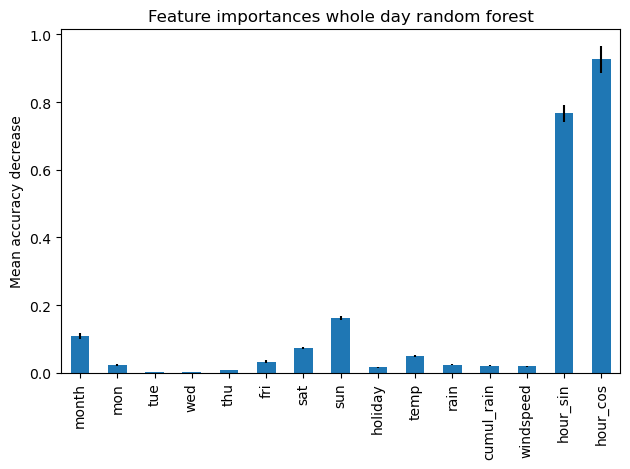

In [26]:
start_time = time.time()
result = permutation_importance(
    finalmodel, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=['month','mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'holiday', 
                                                               'temp', 'rain', 'cumul_rain', 'windspeed', 'hour_sin', 'hour_cos'])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances whole day random forest")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
#This plot measures how much the accuracy of the predictions decrease when one feature is randomly permuted and the others
#Kept constant. In other words, it measures how much the variable contributes to the predictions

#Most important variable by far is the hour, so we also make a night-only model

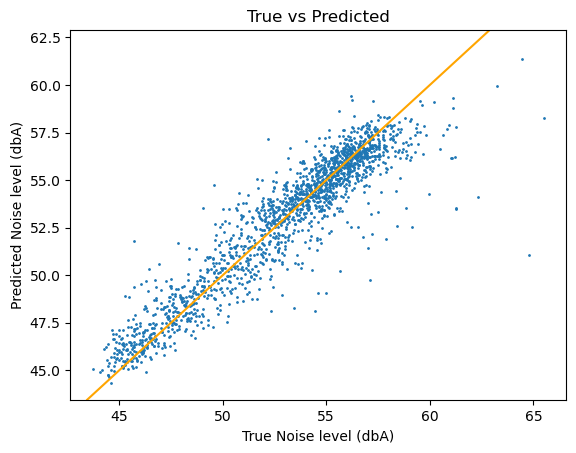

In [25]:
#Plot predicted values against true ones
plt.scatter(y_test, predictions2, s=1)
plt.axline((48, 48), (62, 62), color = 'orange')
plt.xlabel('True Noise level (dbA)')
plt.ylabel('Predicted Noise level (dbA)')
plt.title('True vs Predicted')
plt.show()
#If the predictions were perfect, every point would be on the orange line
#If a point is below the line it is underestimated, if it is above it is overestimated
#For high observations it tends to underestimate, for low it overestimates somewhat
#Somewhat high variance from 45-55, but prediction is very good around 55-60

In [27]:
#nr of over/underestimations to see if the model is particularly biased up/down
num = 0
over = 0
for i in y_test:
    if i < predictions2[[num]]:
        over += 1
    num +=1
print("Overpredictions:", over, "Underpredictions:", len(y_test) - over)

Overpredictions: 879 Underpredictions: 873


**Partial effect of each predictor (Effect on noise with all the other variables kept constant)**

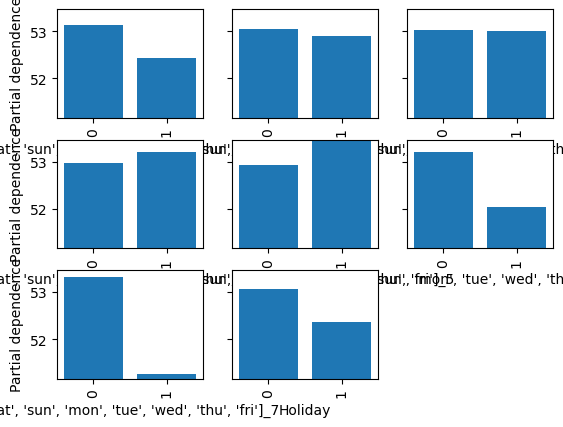

In [63]:
#Plot partial dependence of weekdays + holiday (aligns with the feature importance plot)
PartialDependenceDisplay.from_estimator(finalmodel, features, [1, 2, 3, 4, 5, 6, 7, 8], 
                                        categorical_features= [True, True, True, True, True, True, True, True, True, 
                                                              False, False, False, False, False, False])

#So for example, a public holiday seems to only cause as much decrease in noise from the average as a monday does.
#Sunday has the biggest impact out of all the days in terms of being quieter

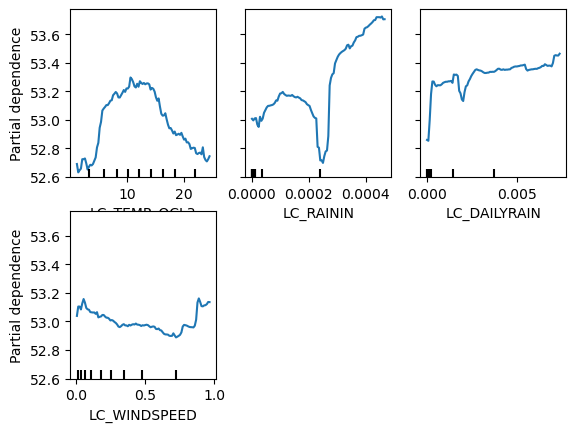

In [44]:
#Plot partial dependence of continuous variables
PartialDependenceDisplay.from_estimator(finalmodel, features, [9, 10, 11, 12])

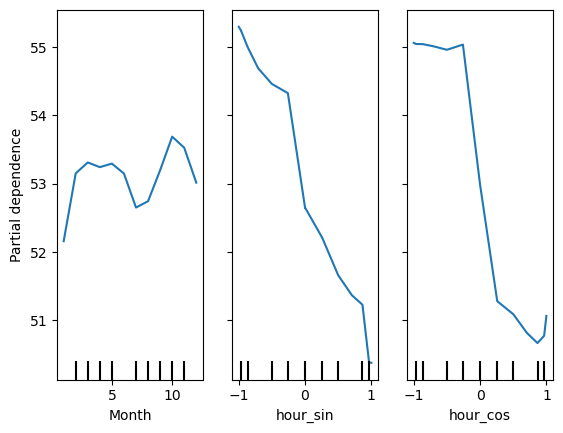

In [27]:
#Plot partial dependence of hour
PartialDependenceDisplay.from_estimator(finalmodel, features, [0, 13, 14])

#Have to imagine these on a unit circle,
#When cos = 1 it's midnight
#When cos = -1 it's noon
#When sin = 1 it's 6AM
#When sin = -1 it's 6PM

#So what these plots are saying is it's much noisier around noon-6PM then around midnight-6PM. Confirms the day-night effect

#In the partial plot for month we clearly see the academic year reflected